# Atmospheric Boundary Layer

The simulation of a atmospheric flow is used for the confirmation wether the solver is able to reproduce a wind tunnel experiment. Through appropriate obstacles arrangement, it is possible to shape the wind profile of a wind tunnel in accordance to wind standards for different wind categories. In the present simulations, plate shaped obstacles are placed over a wind tunnel from inlet. To reduce the development length, the Synthetic Eddy Method is adopted as inlet boundary condition:

![localimage](images/sem_wind_tunnel.svg)

In [1]:
from nassu.cfg.model import ConfigScheme

filename = "tests/validation/cases/06_atmospheric_flow.nassu.yaml"

sim_cfgs = ConfigScheme.sim_cfgs_from_file_dct(filename)

## Velocity Profile

Here the functions used for and turbulent intensity velocity profiles processing used for all cases are defined:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pathlib
from nassu.cfg.schemes.simul import SimulationConfigs
from tests.validation.notebooks import common
from vtk.util.numpy_support import vtk_to_numpy

The floor is delineated with an IBM plane placed at 5.01 nodes height. The scale adopted is such that each LBM node at level 0 correspond to 8 meters. The highest level adopted is 1, with a resolution of 4 meters per node. Only the plates height varied between each case. The plates width was of 12 meters and its spacing of 32x64 meters.

In [3]:
base_height = 5.01
max_height_nodes = 25
height_m_node_lvl0 = 8
n_points = 50


def get_line_for_probe(sim_cfg: SimulationConfigs, x_dist: float) -> np.ndarray:
    global base_height, max_height_nodes, n_points
    ds = sim_cfg.domain.domain_size

    p0 = np.array((x_dist, ds.y // 2, base_height))
    p1 = np.array((x_dist, ds.y // 2, base_height + max_height_nodes))
    pos = np.linspace(p0, p1, num=n_points, endpoint=True)

    return pos

In [4]:
all_readers_outputs = {}


def get_output(sim_cfg: SimulationConfigs):
    global all_readers_outputs

    key = (sim_cfg.name, sim_cfg.sim_id)
    if key in all_readers_outputs:
        return all_readers_outputs[key]
    else:
        # Avoid keeping too many vtms in memory
        all_readers_outputs = {}

    stats_export = sim_cfg.output.stats["full_stats"]
    last_step = stats_export.interval.get_all_process_steps(sim_cfg.n_steps)[-1]
    reader = stats_export.read_vtm_export(last_step)

    all_readers_outputs[key] = reader.GetOutput()
    return all_readers_outputs[key]

In [5]:
def get_macr_values(
    sim_cfg: SimulationConfigs, macr_name: str, is_2nd_order: bool, line: np.ndarray
) -> np.ndarray:
    reader_output = get_output(sim_cfg)

    macr_name_read = macr_name if not is_2nd_order else f"{macr_name}_2nd"

    line = common.create_line(line[0], line[-1], len(line) - 1)

    probe_filter = common.probe_over_line(line, reader_output)
    arr = probe_filter.GetOutput().GetPointData().GetArray(macr_name_read)
    probed_data = vtk_to_numpy(arr)

    return probed_data

Load the comparison data generated using the EU standard for wind categories.

In [6]:
comparison_folder = pathlib.Path("fixture/SEM/category_vprofile")
files = [
    "profile_log_cat0_H150_Uh0.06",
    "profile_log_cat1_H150_Uh0.06",
    "profile_log_cat2_H150_Uh0.06",
    "profile_log_cat3_H150_Uh0.06",
    "profile_log_cat4_H150_Uh0.06",
]
get_filename_csv = lambda f: comparison_folder / (f + ".csv")


df_eu = {f: pd.read_csv(get_filename_csv(f), delimiter=",") for f in files}

for f in files:
    df_eu[f]["Ix"] = (df_eu[f]["Rxx"] / (df_eu[f]["ux"] ** 2)) ** 0.5
    df_eu[f]["zmeters"] = df_eu[f]["z"]

## Power Spectral Density

Here the functions used for the power spectral density (PSD) processing used for all cases are defined:

In [7]:
import scipy
from scipy.ndimage import gaussian_filter

In [8]:
def filter_avg_data(data):
    data = gaussian_filter(data, sigma=0)
    return data


def theoretical_spectrum_x(f_array):
    S_out = np.zeros(len(f_array))
    for i in range(len(f_array)):
        S_out[i] = 6.8 * f_array[i] / (1 + 10.2 * (f_array[i])) ** (5 / 3)
    return S_out


def numerical_spectrum(data_arr, f, L):
    arr = np.array(data_arr, dtype=np.float32).flatten()

    (xf, yf_img) = scipy.signal.periodogram(arr, f, scaling="density")
    avg = np.average(arr)
    st = np.std(arr)
    yf_img = yf_img * (xf) / (st * st)
    xf = xf * (L / avg)

    yf = np.real(yf_img)
    return xf, yf

## Category 0

For the category 0, no obstacles are placed on the plane.

/tmp/ipykernel_3539666/498636194.py:24: RuntimeWarning: invalid value encountered in divide
  Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)


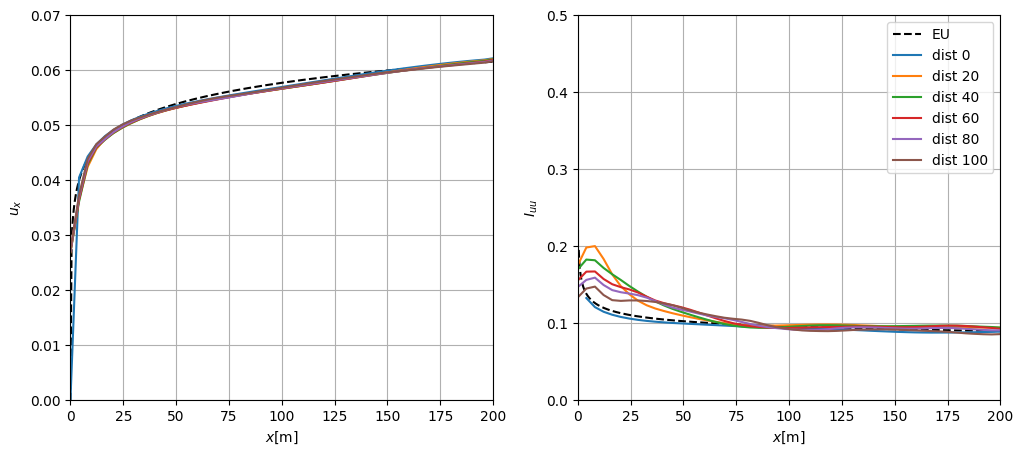

In [9]:
sim_cfg = sim_cfgs["category_0_s4m", 0]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].plot(
    df_eu["profile_log_cat0_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat0_H150_Uh0.06"]["ux"],
    "--k",
    label="EU",
)
ax[1].plot(
    df_eu["profile_log_cat0_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat0_H150_Uh0.06"]["Ix"],
    "--k",
    label="EU",
)

for dist in [0, 20, 40, 60, 80, 100]:
    line01 = get_line_for_probe(sim_cfg, dist)

    ux = get_macr_values(sim_cfg, "ux", is_2nd_order=False, line=line01)
    ux_2nd = get_macr_values(sim_cfg, "ux", is_2nd_order=True, line=line01)
    Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)

    normline = ((line01) - base_height) * height_m_node_lvl0

    ax[0].plot(normline[:, 2], ux, label=f"dist {dist}")
    ax[1].plot(normline[:, 2], Ix, label=f"dist {dist}")

ax[0].set_ylabel("$u_{x}$")
ax[0].set_xlabel("$x$[m]")
ax[0].set_ylim(0, 0.07)
ax[0].set_xlim(0, 200)
ax[0].grid()

ax[1].set_ylabel("$I_{uu}$")
ax[1].set_xlabel("$x$[m]")
ax[1].legend()
ax[1].set_ylim(0, 0.5)
ax[1].set_xlim(0, 200)
ax[1].grid()

plt.show(fig)

It can be noticed a elevated turbulent intensity at low heigth. It must be highlighted that in the first two nodes after the floor, the IBM has its diffusive layer which may contributes to generate turbulence higher than desired near the ground. Such effect could be mitigated by adopting a higher resolution for a terrain with no obstacles. 

In [10]:
def read_df_spectrum(sim_cfg: SimulationConfigs, line_name: str):
    spectrum_series = sim_cfg.output.series["velocity"].lines[line_name]

    df_hs = spectrum_series.read_full_data("ux")
    df_points = pd.read_csv(spectrum_series.points_filename)
    df_hs = df_hs[df_hs["time_step"] >= 10000]

    return df_hs, df_points

In [11]:
pitot_position_x = [10, 50, 100]
pitot_position_y = [80]
pitot_position_z = [10, 50, 100]
freq = 1

pitot_position_z = [round(z * 0.125 + base_height, 4) for z in pitot_position_z]

df_spectrum = []
df_points = []

for pos in pitot_position_x:
    if pos < 100:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_0{pos}")
    else:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_{pos}")
    df_spectrum.append(df_spectrum_aux)
    df_points.append(df_points_aux)

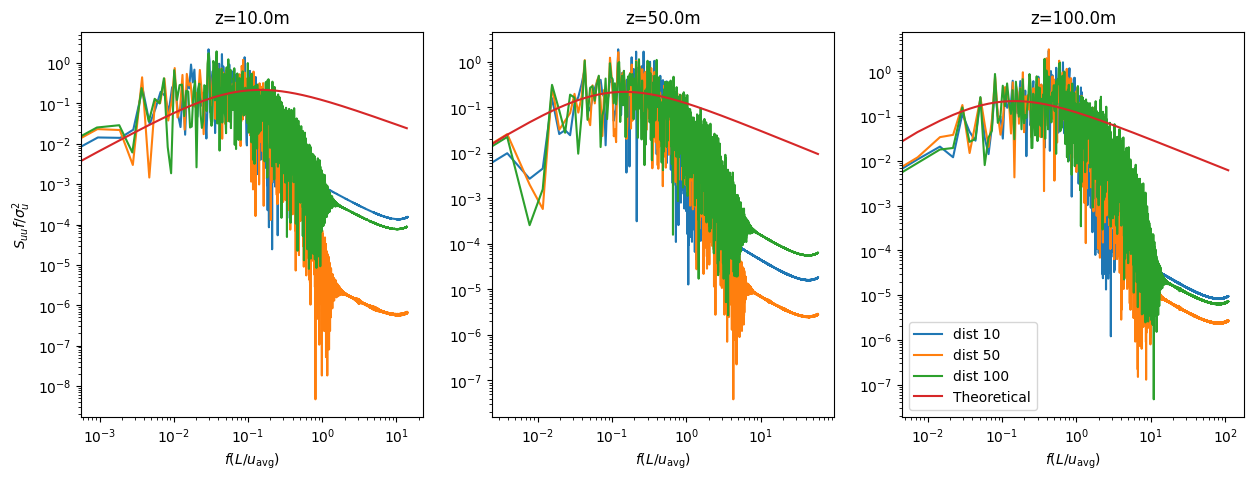

In [12]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
i = 0

for z in pitot_position_z:
    for y in pitot_position_y:
        for j, x in enumerate(pitot_position_x):
            df_probe_id = df_points[j][
                (df_points[j]["x"] == x) & (df_points[j]["y"] == y) & (df_points[j]["z"] == z)
            ].astype(str)
            df_probe_id.reset_index(inplace=True)
            ux_arr = df_spectrum[j][df_probe_id["idx"]]

            # L = get_L(z0[int(abl_category)], (z - floor)*scale)/scale
            H = z - base_height
            nxf, nyf = numerical_spectrum(ux_arr, freq, H)
            yf_theo = theoretical_spectrum_x(nxf)
            yf_avg = filter_avg_data(nyf)
            ax[i].plot(nxf, yf_avg, label=f"dist {x}")
    ax[i].plot(nxf, yf_theo, label="Theoretical")
    ax[i].set_title(f"z={(z-base_height)*height_m_node_lvl0:.1f}m")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].axis([1e-2, 100, 0.001, 1])
    ax[i].set_xlabel("$f(L/u_{\mathrm{avg}})$")
    i += 1

ax[2].legend(loc="lower left")
ax[0].set_ylabel("$S_{uu}f/\sigma_{u}^{2}$")
plt.show()

The power spectral density curves suggest that the flow spectra becomes developed around 80 to 90 nodes. Good agreement of the peak with the theoretical Von Karman curve was obtained at all heights measured 

## Category I

For the category I, plates of 1 meter heigth were considered.

/tmp/ipykernel_3539666/659996709.py:24: RuntimeWarning: invalid value encountered in divide
  Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)


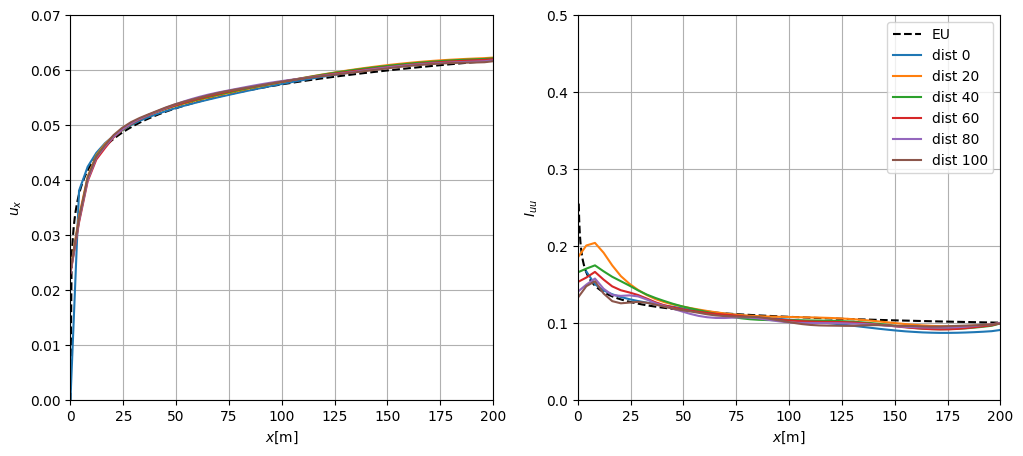

In [13]:
sim_cfg = sim_cfgs["category_1_s4m", 0]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].plot(
    df_eu["profile_log_cat1_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat1_H150_Uh0.06"]["ux"],
    "--k",
    label="EU",
)
ax[1].plot(
    df_eu["profile_log_cat1_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat1_H150_Uh0.06"]["Ix"],
    "--k",
    label="EU",
)

for dist in [0, 20, 40, 60, 80, 100]:
    line01 = get_line_for_probe(sim_cfg, dist)

    ux = get_macr_values(sim_cfg, "ux", is_2nd_order=False, line=line01)
    ux_2nd = get_macr_values(sim_cfg, "ux", is_2nd_order=True, line=line01)
    Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)

    normline = ((line01) - base_height) * height_m_node_lvl0

    ax[0].plot(normline[:, 2], ux, label=f"dist {dist}")
    ax[1].plot(normline[:, 2], Ix, label=f"dist {dist}")

ax[0].set_ylabel("$u_{x}$")
ax[0].set_xlabel("$x$[m]")
ax[0].set_ylim(0, 0.07)
ax[0].set_xlim(0, 200)
ax[0].grid()

ax[1].set_ylabel("$I_{uu}$")
ax[1].set_xlabel("$x$[m]")
ax[1].legend()
ax[1].set_ylim(0, 0.5)
ax[1].set_xlim(0, 200)
ax[1].grid()

plt.show(fig)

Some improvement of from category 0 results was obtained in this case, however the plates heigth occupies only half node in the most refined level. This might not be ideal to obtain the exact turbulent intensity profile. Nevertheless, the profile fit can be considered as very satisfactory.

In [14]:
pitot_position_x = [10, 50, 100]
pitot_position_y = [80]
pitot_position_z = [10, 50, 100]
freq = 1

pitot_position_z = [round(z * 0.125 + base_height, 4) for z in pitot_position_z]

df_spectrum = []
df_points = []

for pos in pitot_position_x:
    if pos < 100:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_0{pos}")
    else:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_{pos}")
    df_spectrum.append(df_spectrum_aux)
    df_points.append(df_points_aux)

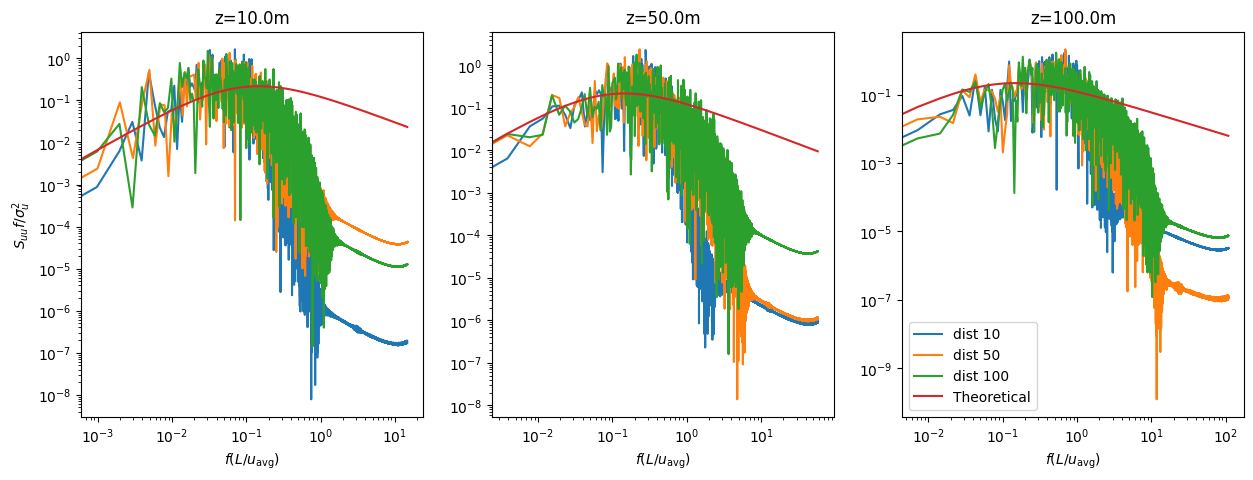

In [15]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
i = 0

for z in pitot_position_z:
    for y in pitot_position_y:
        for j, x in enumerate(pitot_position_x):
            df_probe_id = df_points[j][
                (df_points[j]["x"] == x) & (df_points[j]["y"] == y) & (df_points[j]["z"] == z)
            ].astype(str)
            df_probe_id.reset_index(inplace=True)
            ux_arr = df_spectrum[j][df_probe_id["idx"]]

            # L = get_L(z0[int(abl_category)], (z - floor)*scale)/scale
            H = z - base_height
            nxf, nyf = numerical_spectrum(ux_arr, freq, H)
            yf_theo = theoretical_spectrum_x(nxf)
            yf_avg = filter_avg_data(nyf)
            ax[i].plot(nxf, yf_avg, label=f"dist {x}")
    ax[i].plot(nxf, yf_theo, label="Theoretical")
    ax[i].set_title(f"z={(z-base_height)*height_m_node_lvl0:.1f}m")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].axis([1e-2, 100, 0.001, 1])
    ax[i].set_xlabel("$f(L/u_{\mathrm{avg}})$")
    i += 1

ax[2].legend(loc="lower left")
ax[0].set_ylabel("$S_{uu}f/\sigma_{u}^{2}$")
plt.show()

Again, the spectrum seem to become developed between 80 and 90 nodes from inlet.

## Category II

To mantain the category II profiles, plates of 2m high were used.

/tmp/ipykernel_3539666/3024386814.py:24: RuntimeWarning: invalid value encountered in divide
  Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)


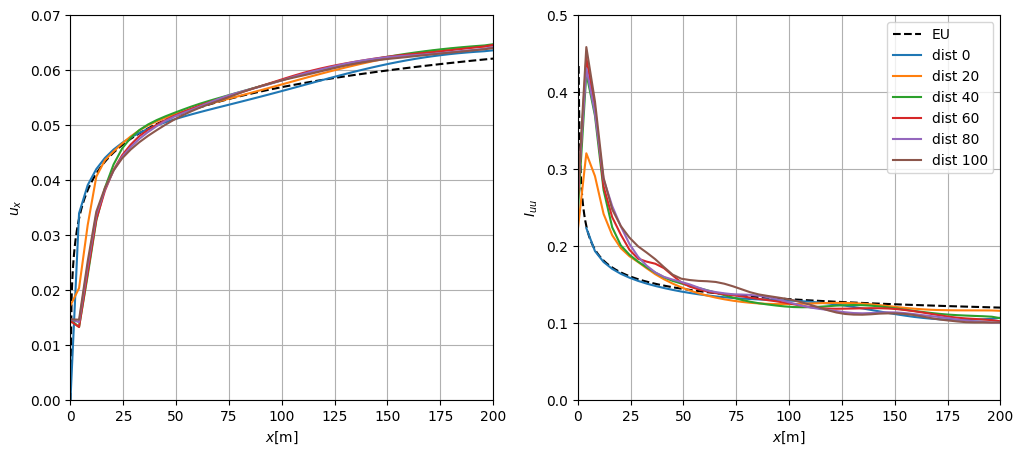

In [16]:
sim_cfg = sim_cfgs["category_2_s4m", 0]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].plot(
    df_eu["profile_log_cat2_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat2_H150_Uh0.06"]["ux"],
    "--k",
    label="EU",
)
ax[1].plot(
    df_eu["profile_log_cat2_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat2_H150_Uh0.06"]["Ix"],
    "--k",
    label="EU",
)

for dist in [0, 20, 40, 60, 80, 100]:
    line01 = get_line_for_probe(sim_cfg, dist)

    ux = get_macr_values(sim_cfg, "ux", is_2nd_order=False, line=line01)
    ux_2nd = get_macr_values(sim_cfg, "ux", is_2nd_order=True, line=line01)
    Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)

    normline = ((line01) - base_height) * height_m_node_lvl0

    ax[0].plot(normline[:, 2], ux, label=f"dist {dist}")
    ax[1].plot(normline[:, 2], Ix, label=f"dist {dist}")

ax[0].set_ylabel("$u_{x}$")
ax[0].set_xlabel("$x$[m]")
ax[0].set_ylim(0, 0.07)
ax[0].set_xlim(0, 200)
ax[0].grid()

ax[1].set_ylabel("$I_{uu}$")
ax[1].set_xlabel("$x$[m]")
ax[1].legend()
ax[1].set_ylim(0, 0.5)
ax[1].set_xlim(0, 200)
ax[1].grid()

plt.show(fig)

It can be seen good agreement from around 15m and above. To improve the results below this height a finer grid to correctly compute the elevated velocity gradient would be necessary.

In [17]:
pitot_position_x = [10, 50, 100]
pitot_position_y = [80]
pitot_position_z = [10, 50, 100]
freq = 1

pitot_position_z = [round(z * 0.125 + base_height, 4) for z in pitot_position_z]

df_spectrum = []
df_points = []

for pos in pitot_position_x:
    if pos < 100:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_0{pos}")
    else:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_{pos}")
    df_spectrum.append(df_spectrum_aux)
    df_points.append(df_points_aux)

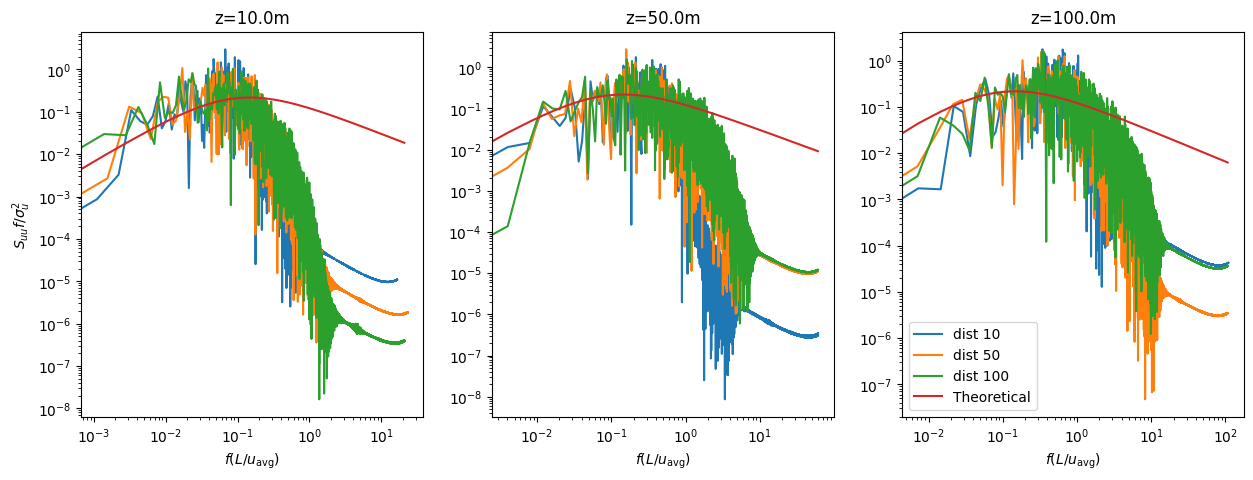

In [18]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
i = 0

for z in pitot_position_z:
    for y in pitot_position_y:
        for j, x in enumerate(pitot_position_x):
            df_probe_id = df_points[j][
                (df_points[j]["x"] == x) & (df_points[j]["y"] == y) & (df_points[j]["z"] == z)
            ].astype(str)
            df_probe_id.reset_index(inplace=True)
            ux_arr = df_spectrum[j][df_probe_id["idx"]]

            # L = get_L(z0[int(abl_category)], (z - floor)*scale)/scale
            H = z - base_height
            nxf, nyf = numerical_spectrum(ux_arr, freq, H)
            yf_theo = theoretical_spectrum_x(nxf)
            yf_avg = filter_avg_data(nyf)
            ax[i].plot(nxf, yf_avg, label=f"dist {x}")
    ax[i].plot(nxf, yf_theo, label="Theoretical")
    ax[i].set_title(f"z={(z-base_height)*height_m_node_lvl0:.1f}m")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].axis([1e-2, 100, 0.001, 1])
    ax[i].set_xlabel("$f(L/u_{\mathrm{avg}})$")
    i += 1

ax[2].legend(loc="lower left")
ax[0].set_ylabel("$S_{uu}f/\sigma_{u}^{2}$")
plt.show()

The spectrum deviates from theoretical peak at 10 meters possibly due to influence of obstacles, a simulation at higher resolution could also change this aspect. Above this height the spectrum tends to follow the theoretical Von Karman curve.

## Category III

To mantain the category III profile from inlet, plates of 6 meters were adopted.

/tmp/ipykernel_3539666/3855561526.py:24: RuntimeWarning: invalid value encountered in divide
  Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)


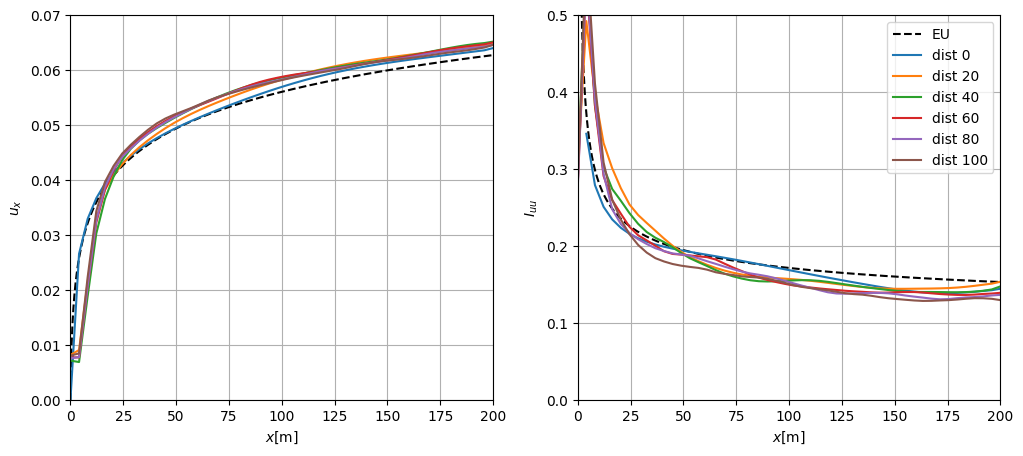

In [19]:
sim_cfg = sim_cfgs["category_3_s4m", 0]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].plot(
    df_eu["profile_log_cat3_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat3_H150_Uh0.06"]["ux"],
    "--k",
    label="EU",
)
ax[1].plot(
    df_eu["profile_log_cat3_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat3_H150_Uh0.06"]["Ix"],
    "--k",
    label="EU",
)

for dist in [0, 20, 40, 60, 80, 100]:
    line01 = get_line_for_probe(sim_cfg, dist)

    ux = get_macr_values(sim_cfg, "ux", is_2nd_order=False, line=line01)
    ux_2nd = get_macr_values(sim_cfg, "ux", is_2nd_order=True, line=line01)
    Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)

    normline = ((line01) - base_height) * height_m_node_lvl0

    ax[0].plot(normline[:, 2], ux, label=f"dist {dist}")
    ax[1].plot(normline[:, 2], Ix, label=f"dist {dist}")

ax[0].set_ylabel("$u_{x}$")
ax[0].set_xlabel("$x$[m]")
ax[0].set_ylim(0, 0.07)
ax[0].set_xlim(0, 200)
ax[0].grid()

ax[1].set_ylabel("$I_{uu}$")
ax[1].set_xlabel("$x$[m]")
ax[1].legend()
ax[1].set_ylim(0, 0.5)
ax[1].set_xlim(0, 200)
ax[1].grid()

plt.show(fig)

In this case, the turbulence occurs in larger scales and the obstacles are better perceived by the simulation since they occupy more than a single node.The obtained profiles over the domain have excellent agreement with the inlet profile.

In [20]:
pitot_position_x = [10, 50, 100]
pitot_position_y = [80]
pitot_position_z = [10, 50, 100]
freq = 1

pitot_position_z = [round(z * 0.125 + base_height, 4) for z in pitot_position_z]

df_spectrum = []
df_points = []

for pos in pitot_position_x:
    if pos < 100:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_0{pos}")
    else:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_{pos}")
    df_spectrum.append(df_spectrum_aux)
    df_points.append(df_points_aux)

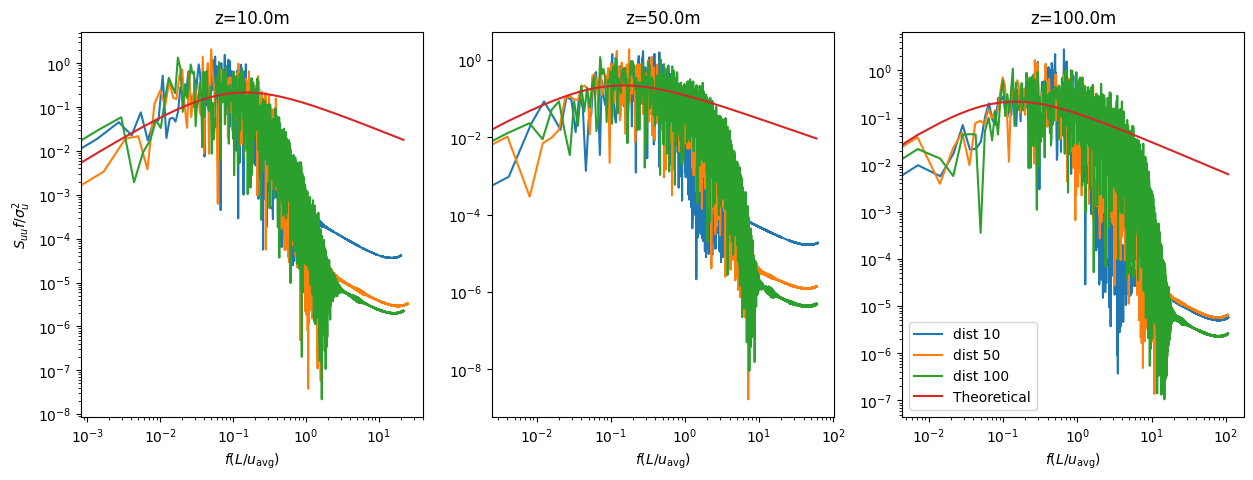

In [21]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
i = 0

for z in pitot_position_z:
    for y in pitot_position_y:
        for j, x in enumerate(pitot_position_x):
            df_probe_id = df_points[j][
                (df_points[j]["x"] == x) & (df_points[j]["y"] == y) & (df_points[j]["z"] == z)
            ].astype(str)
            df_probe_id.reset_index(inplace=True)
            ux_arr = df_spectrum[j][df_probe_id["idx"]]

            # L = get_L(z0[int(abl_category)], (z - floor)*scale)/scale
            H = z - base_height
            nxf, nyf = numerical_spectrum(ux_arr, freq, H)
            yf_theo = theoretical_spectrum_x(nxf)
            yf_avg = filter_avg_data(nyf)
            ax[i].plot(nxf, yf_avg, label=f"dist {x}")
    ax[i].plot(nxf, yf_theo, label="Theoretical")
    ax[i].set_title(f"z={(z-base_height)*height_m_node_lvl0:.1f}m")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].axis([1e-2, 100, 0.001, 1])
    ax[i].set_xlabel("$f(L/u_{\mathrm{avg}})$")
    i += 1

ax[2].legend(loc="lower left")
ax[0].set_ylabel("$S_{uu}f/\sigma_{u}^{2}$")
plt.show()

Again, the curve at 10 meters seems to be displaced. In general, the spectrum seems to develop earlier in comparison to the previous categories.

## Category IV

The plates used to maintain the category IV profile were 10 meters high.

/tmp/ipykernel_3539666/3194715471.py:24: RuntimeWarning: invalid value encountered in divide
  Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)


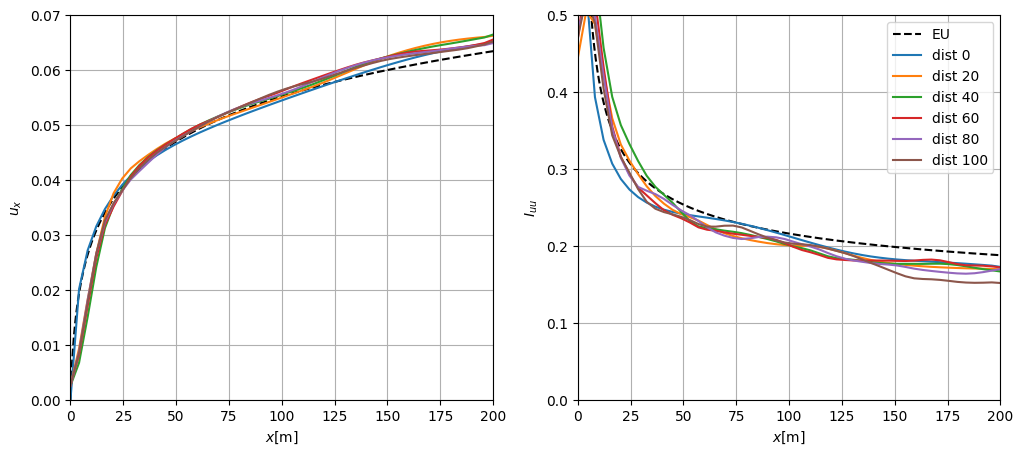

In [22]:
sim_cfg = sim_cfgs["category_4_s4m", 0]

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(12, 5)

ax[0].plot(
    df_eu["profile_log_cat4_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat4_H150_Uh0.06"]["ux"],
    "--k",
    label="EU",
)
ax[1].plot(
    df_eu["profile_log_cat4_H150_Uh0.06"]["zmeters"],
    df_eu["profile_log_cat4_H150_Uh0.06"]["Ix"],
    "--k",
    label="EU",
)

for dist in [0, 20, 40, 60, 80, 100]:
    line01 = get_line_for_probe(sim_cfg, dist)

    ux = get_macr_values(sim_cfg, "ux", is_2nd_order=False, line=line01)
    ux_2nd = get_macr_values(sim_cfg, "ux", is_2nd_order=True, line=line01)
    Ix = ((ux_2nd - (ux**2)) / (ux**2)) ** (0.5)

    normline = ((line01) - base_height) * height_m_node_lvl0

    ax[0].plot(normline[:, 2], ux, label=f"dist {dist}")
    ax[1].plot(normline[:, 2], Ix, label=f"dist {dist}")

ax[0].set_ylabel("$u_{x}$")
ax[0].set_xlabel("$x$[m]")
ax[0].set_ylim(0, 0.07)
ax[0].set_xlim(0, 200)
ax[0].grid()

ax[1].set_ylabel("$I_{uu}$")
ax[1].set_xlabel("$x$[m]")
ax[1].legend()
ax[1].set_ylim(0, 0.5)
ax[1].set_xlim(0, 200)
ax[1].grid()

plt.show(fig)

Excellent agreement between the developed profile and the EU standard for the category IV was obtained.

In [23]:
pitot_position_x = [10, 50, 100]
pitot_position_y = [80]
pitot_position_z = [10, 50, 100]
freq = 1

pitot_position_z = [round(z * 0.125 + base_height, 4) for z in pitot_position_z]

df_spectrum = []
df_points = []

for pos in pitot_position_x:
    if pos < 100:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_0{pos}")
    else:
        df_spectrum_aux, df_points_aux = read_df_spectrum(sim_cfg, f"velocity_profile_{pos}")
    df_spectrum.append(df_spectrum_aux)
    df_points.append(df_points_aux)

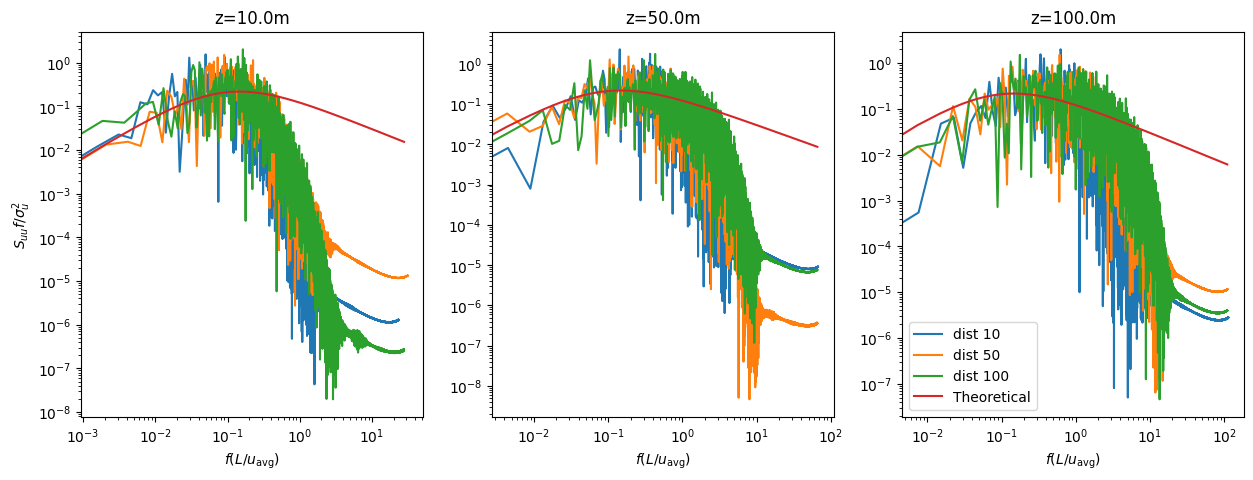

In [24]:
fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 5)
i = 0

for z in pitot_position_z:
    for y in pitot_position_y:
        for j, x in enumerate(pitot_position_x):
            df_probe_id = df_points[j][
                (df_points[j]["x"] == x) & (df_points[j]["y"] == y) & (df_points[j]["z"] == z)
            ].astype(str)
            df_probe_id.reset_index(inplace=True)
            ux_arr = df_spectrum[j][df_probe_id["idx"]]

            # L = get_L(z0[int(abl_category)], (z - floor)*scale)/scale
            H = z - base_height
            nxf, nyf = numerical_spectrum(ux_arr, freq, H)
            yf_theo = theoretical_spectrum_x(nxf)
            yf_avg = filter_avg_data(nyf)
            ax[i].plot(nxf, yf_avg, label=f"dist {x}")
    ax[i].plot(nxf, yf_theo, label="Theoretical")
    ax[i].set_title(f"z={(z-base_height)*height_m_node_lvl0:.1f}m")
    ax[i].set_xscale("log")
    ax[i].set_yscale("log")
    # ax[i].axis([1e-2, 100, 0.001, 1])
    ax[i].set_xlabel("$f(L/u_{\mathrm{avg}})$")
    i += 1

ax[2].legend(loc="lower left")
ax[0].set_ylabel("$S_{uu}f/\sigma_{u}^{2}$")
plt.show()

In this case the spectrum seems to develop even earlier in comparison to previous simulations.

## Version

In [25]:
sim_info = sim_cfg.output.read_info()

nassu_commit = sim_info["commit"]
nassu_version = sim_info["version"]
print("Version:", nassu_version)
print("Commit hash:", nassu_commit)

Version: 1.6.17
Commit hash: 5df3ec0ad15e12b77724741bae33d94b7ff021d9


## Configuration

In [26]:
from IPython.display import Code

Code(filename=filename)

variables:
  simul:
    dev_time: 10000
    stats_time: 60000
    scale: !math 1/8
    plane_height: 5.01
    sigma_sem: 20
  domain:
    length: 600
    width: 160
    height: 112
  refine: &ANCHOR_VOLUMES_REFINE
    - start: [0.0, 55.0, 0.0]
      end: [336.0, 105.0, 32.0]
      lvl: 1
      is_abs: true
  var:
    15m_height: !math ${simul.plane_height} + (15 * ${simul.scale})
    150m_height: !math ${simul.plane_height} + (150 * ${simul.scale})

## Same variables to dependencies

simulations:
  - name: category_0_s4m
    save_path: ./tests/validation/results/06_atmospheric_flow
    run_simul: true

    n_steps: !math "${simul.dev_time} + ${simul.stats_time}"

    debug:
      profile: false
      output_only: false
      output_IBM_nodes: false
      multiblock:
        run_communication: true
        export_comm_vtk: false
        export_used_nodes: true

    report:
      frequency: 500
    checkpoint:
      export:
        interval:
          {
            end_step: !math "${simul.dev_time} + ${simul.stats_time}",
            frequency: 10000,
            start_step: !math "${simul.dev_time}",
          }
        finish_save: true
        keep_only_last_checkpoint: true

    data:
      divergence: { frequency: 1 }
      monitors:
        fields:
          macrs_stats:
            macrs: [rho, u]
            stats: [min, max, mean]
            interval:
              {
                start_step: 0,
                end_step: !math "${simul.dev_time} + ${simul.stats_time}",
                frequency: 10,
              }
      instantaneous:
        full_domain: { interval: { frequency: 0 }, macrs: [rho, u] }
      statistics:
        interval: { frequency: 10, start_step: !sub "${simul.dev_time}" }
        macrs_1st_order: [rho, u]
        macrs_2nd_order: [u]
        exports:
          full_stats: { interval: { frequency: 0 } }
      probes:
        historic_series:
          velocity:
            macrs: ["u"]
            interval: { frequency: 2, lvl: 0, start_step: !sub "${simul.dev_time}" }
            lines:
              velocity_profile_000:
                dist: 0.0625
                start_pos: !math [0, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [0, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_010:
                dist: 0.0625
                start_pos: !math [10, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [10, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_020:
                dist: 0.0625
                start_pos: !math [20, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [20, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_030:
                dist: 0.0625
                start_pos: !math [30, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [30, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_040:
                dist: 0.0625
                start_pos: !math [40, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [40, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_050:
                dist: 0.0625
                start_pos: !math [50, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [50, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_060:
                dist: 0.0625
                start_pos: !math [60, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [60, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_profile_070:
                dist: 0.0625
                start_pos: !math [70, "0.5*${domain.width}", "${simul.plane_height}"]
                end_pos: !math [70, "0.5*${domain.width}", "${simul.plane_height} + 64"]
              velocity_prof